<h1><center> Manga: Single Galaxy Calculations <center></h1>
<center> An attempt to get the H\delta_{a} and Dn4000 values for a single galaxy as a function of radius: once we get this running, we can modularize everything! <center>

In [1]:
from __future__ import unicode_literals
import numpy as np
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
import scipy.interpolate as interp
import scipy.stats as st
import scipy.signal as sig
from scipy.optimize import curve_fit


import h5py
import gc
import sys
import subprocess
import pickle
import os


import astropy as ap
from astropy.io import fits
from astropy import table as t
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import WMAP7


import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1

In [2]:
def get_dn4000(wave,spec):
    interp_spec = interp.interp1d(wave,spec)
    blue_wav = np.linspace(3850,3950,100)
    red_wav = np.linspace(4000,4100,100)
    d4000 = np.sum(interp_spec(red_wav)) / np.sum(interp_spec(blue_wav))
    return d4000

def get_HdA(wave,spec):
    bandw_HdA = np.logical_and(wave > 4083.500, wave < 4122.250)   # analogous to MPA-JHU
    bandw_HdA_blueside = np.logical_and(wave > 4041.600, wave < 4079.750)
    bandw_HdA_redside = np.logical_and(wave > 4128.500, wave < 4161.000)
    spec_av_blueside = np.sum(spec[bandw_HdA_blueside])/len(spec[bandw_HdA_blueside])
    spec_av_redside = np.sum(spec[bandw_HdA_redside])/len(spec[bandw_HdA_redside])
    a_spec = (spec_av_redside - spec_av_blueside)/((4161.000+4128.500)/2 - (4079.750+4041.600)/2)
    b_spec = spec_av_blueside - a_spec * (4079.750+4041.600)/2
    spec_cont_HdA = wave[bandw_HdA] * a_spec + b_spec
    HdA = tsum(wave[bandw_HdA],np.divide((spec_cont_HdA - spec[bandw_HdA]), spec_cont_HdA))
    return HdA

def tsum(xin, yin):
    tsum = np.sum(np.abs((xin[1:]-xin[:-1]))*(yin[1:]+yin[:-1])/2. )
    return tsum

In [3]:
# dat = Table.read('manga-8455-3701-LOGCUBE.fits', format='fits')
# drpall = t.Table.read('drpall-v2_0_1.fits')
# drpall.add_index('plateifu')
# drpall.loc['8455-3701']

# drp_logcube = fits.open('manga-8455-3701-LOGCUBE.fits')
# drp_logcube.info()

In [14]:
os.chdir("/Users/nitya/Work/Data/Project2/manga_cubes")

dat2 = Table.read('manga-9890-12702-LOGCUBE.fits', format='fits')
drpall2 = t.Table.read('drpall-v2_5_3.fits')
drpall2.add_index('plateifu')
drpall2.loc['9890-12702']

drp_logcube2 = fits.open('manga-9890-12702-LOGCUBE.fits')

In [82]:
drpall2['plateifu']

10001-12701
10001-12702
10001-12703
10001-12704
10001-12705
10001-1901
10001-1902
10001-3701
10001-3702
10001-3703
10001-3704


In [84]:
drpall2['plateifu'=='9890-12702']

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes21,bytes11,bytes22,bytes6,bytes6,bytes6,bytes7,bytes4,bytes14,bytes12,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes35,int64,bytes11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes19,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v2_5_3,v2_5_3,v1_7_1,v5_5_33,v2_6,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.2774,41.5828,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78276,1.85945,2.13116,0.899192,0.930249,0.936709,57372,57373,57373,2.69856,2.64784,2.60184,2.54916,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08789,1.19925,-999.0,0.66562,0.705713,203,1350,6,v1_0_1,51226,-999,0.0392074,0.0395926,-16.2982 .. -19.5112,-16.2321 .. -19.5522,275.541 .. 452.944,3068010000.0,2685340000.0,0.417013,69.2463,0.448783 .. 0.0800664,5.16633,3.63987,12.7947 .. 413.049,3.26768 .. 0.000422625,13.8306 .. 425.941,3.03694 .. 0.00496838,0.335333,0.741845,68.2584,5.29184,14.8124 .. 412.19,2.50888 .. 0.0150605


In [15]:
drp_logcube2.info()

Filename: manga-9890-12702-LOGCUBE.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   ()      
  1  FLUX          1 ImageHDU       100   (74, 74, 4563)   float32   
  2  IVAR          1 ImageHDU        17   (74, 74, 4563)   float32   
  3  MASK          1 ImageHDU        17   (74, 74, 4563)   int32   
  4  DISP          1 ImageHDU        11   (74, 74, 4563)   float32   
  5  PREDISP       1 ImageHDU        11   (74, 74, 4563)   float32   
  6  WAVE          1 ImageHDU         9   (4563,)   float64   
  7  SPECRES       1 ImageHDU         9   (4563,)   float64   
  8  SPECRESD      1 ImageHDU         9   (4563,)   float64   
  9  PRESPECRES    1 ImageHDU         9   (4563,)   float64   
 10  PRESPECRESD    1 ImageHDU         9   (4563,)   float64   
 11  OBSINFO       1 BinTableHDU    148   9R x 65C   [25A, 17A, 5A, J, I, 8A, E, E, E, E, E, E, J, J, I, J, E, 12A, J, 8A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 13A

6661
(4563, 74, 74)
['XTENSION', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'PCOUNT', 'GCOUNT', 'AUTHOR', 'VERSDRP2', 'VERSDRP3', 'VERSPLDS', 'VERSFLAT', 'VERSCORE', 'VERSPRIM', 'VERSUTIL', 'VERSIDL', 'BSCALE', 'BZERO', 'BUNIT', 'MASKNAME', 'TELESCOP', 'INSTRUME', 'SRVYMODE', 'PLATETYP', 'OBJSYS', 'EQUINOX', 'RADESYS', 'LAMPLIST', 'TPLDATA', 'NEXP', 'EXPTIME', 'BLUESN2', 'REDSN2', 'AIRMSMIN', 'AIRMSMED', 'AIRMSMAX', 'SEEMIN', 'SEEMED', 'SEEMAX', 'TRANSMIN', 'TRANSMED', 'TRANSMAX', 'MJDMIN', 'MJDMED', 'MJDMAX', 'DATE-OBS', 'MJDRED', 'DATERED', 'MNGTARG1', 'MNGTARG2', 'MNGTARG3', 'IFURA', 'IFUDEC', 'OBJRA', 'OBJDEC', 'CENRA', 'CENDEC', 'PLATEID', 'DESIGNID', 'IFUDSGN', 'FRLPLUG', 'PLATEIFU', 'CARTID', 'HARNAME', 'METFILE', 'MANGAID', 'CATIDNUM', 'PLTTARG', 'DRP3QUAL', 'IFUGLON', 'IFUGLAT', 'EBVGAL', 'GFWHM', 'RFWHM', 'IFWHM', 'ZFWHM', 'CTYPE3', 'CRPIX3', 'CRVAL3', 'CD3_3', 'CUNIT3', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 'CD1_1', 'CD2_2', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'H

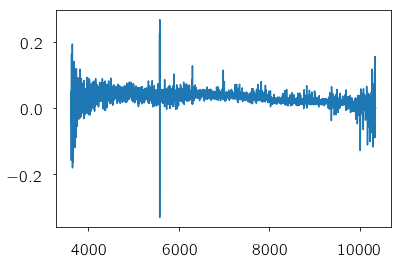

In [16]:
index = np.where(drpall2['srvymode']=='MaNGA dither')[0]
print(len(np.unique(drpall2['plateifu'][index])))
print(drp_logcube2['FLUX'].data.shape)
print(list(drp_logcube2['FLUX'].header.keys()))
NL, NY, NX = drp_logcube2['FLUX'].data.shape
print(drp_logcube2['FLUX'].data[:,17,17])
plt.plot(drp_logcube2['WAVE'].data, drp_logcube2['FLUX'].data[:,17,23])
plt.show()

In [17]:
a = ([[get_dn4000(drp_logcube2['WAVE'].data, drp_logcube2['FLUX'].data[:,i,j]) for j in range(NY)] for i in range(NX)])
b = ([[get_HdA(drp_logcube2['WAVE'].data, drp_logcube2['FLUX'].data[:,i,j]) for j in range(NY)] for i in range(NX)])

/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [18]:
ting = ([[tsum(drp_logcube2['WAVE'].data, drp_logcube2['FLUX'].data[:,i,j]) for j in range(NY)] for i in range(NX)])

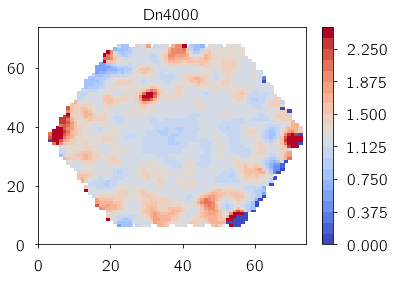

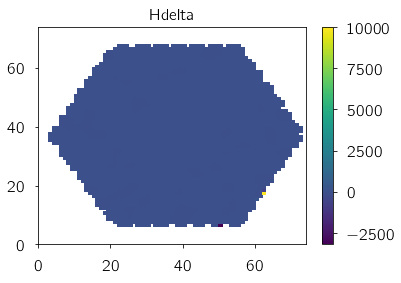

2221
5476
312
257


/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


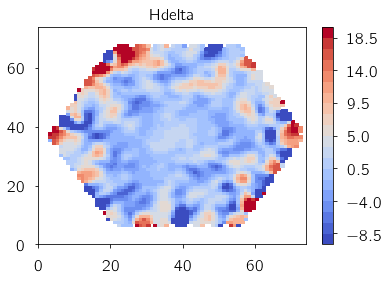

In [29]:
from matplotlib import colors

bounds0 = np.linspace(0.0, 2.5, 21)
norm0 = colors.BoundaryNorm(boundaries=bounds0, ncolors=256)

plt.pcolormesh(a, norm = norm0,  cmap = plt.cm.coolwarm)
plt.colorbar()
plt.title('Dn4000')
plt.show()

plt.pcolormesh(b)
plt.colorbar()
plt.title('Hdelta')
plt.show()
hda = np.ravel(b)
print(len(hda[np.isnan(hda)]))
print(len(hda))
print(len(hda[hda<-5]))
print(len(hda[hda>10]))

bounds1 = np.linspace(-10.0, 20.0, 21)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)

plt.pcolormesh(b, norm = norm1, cmap = plt.cm.coolwarm)
plt.colorbar()
plt.title('Hdelta')
plt.show()

[-36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5
 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5
 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5
  -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5
  11.5  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5
  23.5  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5
  35.5  36.5]
74


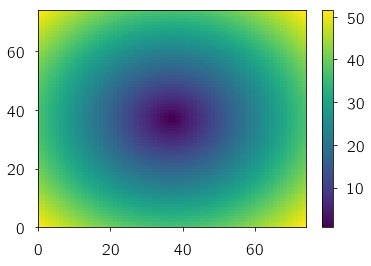

In [171]:
x_ax = np.arange(0, NX) + 0.5 - (NX/2.0)
print(x_ax)
print(len(x_ax))

y = np.outer((np.arange(0, NX) + 0.5) - (NX/2.0), np.ones(NX))
x = np.transpose(y)
s = np.sqrt((x*x+y*y))
plt.pcolormesh(s)
plt.colorbar()
plt.show()
index =np.where(np.ravel(s)<=3.0)[0]
# print(index)
# print(np.ravel(s)[index])
# print(21.5*(2**0.5))
# print(np.max(s))

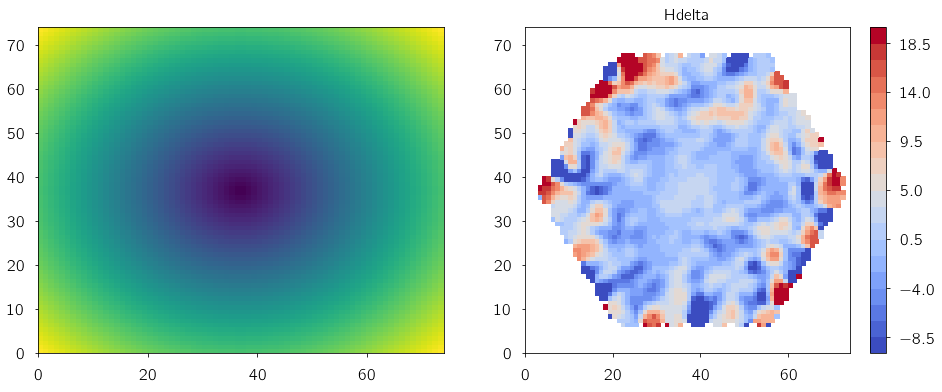

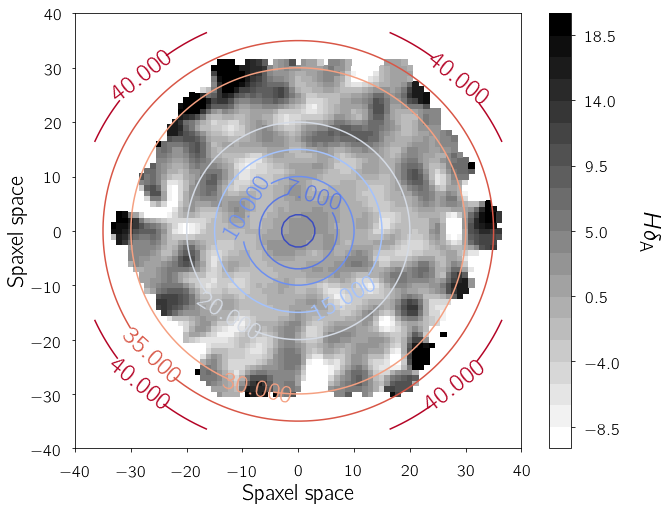

In [31]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (16,6))
cs1 = ax1.pcolormesh(s)
#plt.colorbar(cs1)
cs2 = ax2.pcolormesh(b, norm = norm1, cmap = plt.cm.coolwarm)
plt.colorbar(cs2)
plt.title('Hdelta')
#plt.savefig('galaxy-9487-12701a.pdf')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (10,8))
cs1 = ax.pcolormesh(x_ax,x_ax,b,norm = norm1,  cmap = plt.cm.binary)

bounds2 = np.linspace(3, 40.0, 21)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)
l = [3.0, 7.0, 10.0, 15.0, 20.0, 30.0, 35.0, 40.0]
cs2 = ax.contour(x_ax,x_ax,s, levels = l,norm = norm2, cmap = plt.cm.coolwarm)
plt.clabel(cs2, fontsize = 25)
plt.colorbar(cs1)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel('Spaxel space')
plt.ylabel('Spaxel space')
fig.text(0.92, 0.5, r'$H\delta_{\rm A}$', 
          rotation=270, ha='center', va='center', fontsize = 25)
#plt.savefig('/Users/Nitya/Desktop/gal_aperture.pdf')
plt.show()

In [32]:
tings = np.ravel(ting)
print(len(tings[tings<=1]))
ting = np.array(ting)
number = np.ma.array(ting, mask = ting <= 10)

2123


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
cs1 = ax.pcolormesh(x_ax,x_ax,number,norm = colors.LogNorm(), cmap = plt.cm.Greys)
l = [3.0, 7.0, 10.0, 15.0, 20.0, 30.0, 35.0, 40.0]
cs2 = ax.contour(x_ax,x_ax,s, levels = l, cmap = plt.cm.Blues)
plt.clabel(cs2, fontsize = 15)
plt.xlim(-37,37)
plt.ylim(-37,37)
plt.xlabel('Spaxel space')
plt.ylabel('Spaxel space')
cbar_ax = fig.add_axes([0.13, 0.93, 0.75, 0.01])
cb = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.tick_params(labelsize=13)
fig.text(0.5, 0.9, r'\textit{(Total flux from each spaxel)}', 
         ha='center', va='center', fontsize = 15)
plt.savefig('/Users/Nitya/Desktop/gal_aperture.pdf')
plt.show()

In [146]:
import astropy as ap
from astropy.io import fits
from astropy import table as t
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import WMAP9 as cosmo

In [90]:
# y = np.outer((np.arange(0, NX) + 0.5) - (NX/2.0),
#                           np.ones(NX))
# x = np.transpose(y)
# grid = np.sqrt((y*y + x*x))
# radii = np.ravel(grid)
# def get_radii(z_new, radii):
#     #gets you the new radii for any redshift
#     #radii_new = (1+z_new)*comdis(z_obs)*radii/((1+z_obs)*comdis(z_new))
#     radii_new = ((1+z_new)*cosmo.comoving_distance(0.0392)*
#                      radii)/((1+0.0392)*cosmo.comoving_distance(z_new))
#     return np.array(radii_new)

In [147]:
def rad(z_new):
    r = (3*(1+0.0392)*cosmo.comoving_distance(z_new)
        )/((1+z_new)*cosmo.comoving_distance(0.0392))
    return r

In [176]:
radz = np.round(rad(np.array([0.0392,0.06,0.1,0.14, 0.5])),decimals = 2)

In [177]:
radz

<Quantity [ 3.  ,  4.48,  7.13,  9.55, 23.69]>

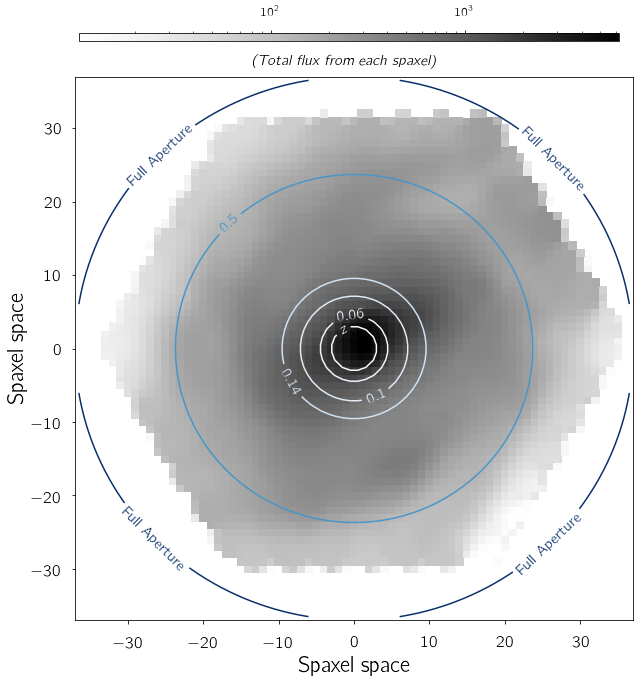

In [179]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
cs1 = ax.pcolormesh(x_ax,x_ax,number,norm = colors.LogNorm(), cmap = plt.cm.Greys)
l = [3, 4.48, 7.13, 9.55, 23.69, 37]
cs2 = ax.contour(x_ax,x_ax,s, levels = l, cmap = plt.cm.Blues)
fmt = {}
strs = [r'$z$', '0.06','0.1','0.14','0.5','Full Aperture']
for l,t in zip(cs2.levels, strs ):
    fmt[l] = t
plt.clabel(cs2, fontsize = 15, fmt = fmt)
plt.xlim(-37,37)
plt.ylim(-37,37)
plt.xlabel('Spaxel space')
plt.ylabel('Spaxel space')
cbar_ax = fig.add_axes([0.13, 0.93, 0.75, 0.01])
cb = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.tick_params(labelsize=13)
fig.text(0.5, 0.9, r'\textit{(Total flux from each spaxel)}', 
         ha='center', va='center', fontsize = 15)
plt.savefig('/Users/Nitya/Desktop/gal_aperture_redshifts.pdf')
plt.show()

In [157]:
cosmo.comoving_distance(0.4), cosmo.comoving_distance(1.4), cosmo.comoving_distance(5.4)

(<Quantity 1572.76745203 Mpc>,
 <Quantity 4256.9350422 Mpc>,
 <Quantity 8177.00501345 Mpc>)

In [ ]:
es = np.ravel(np.array(s))
be = np.ravel(np.array(b))

newbie = es[(es>3.) & (es<=5.)]
print(len(newbie))
print(newbie)

news = be[(es>3.) & (es<=5.)]
print(len(news))
print(news)

In [ ]:
wavez = drp_logcube2['WAVE'].data
print(np.shape(wavez))
flucks = drp_logcube2['FLUX'].data
print(np.shape(flucks))
print(flucks[:,22,22])
print(np.ravel(flucks))
#spec = np.array(flucks[:,i,j])

In [ ]:
bl = []
for i in range(NX):
    for j in range(NY):
        thing = flucks[:,i,j]
        bl.append(thing)
        
print(bl[0:10])
print(be[5000])
print(len(bl[5000]))
print(get_HdA(wavez,bl[5000]))

In [ ]:
bl = np.array(bl)
print(np.shape(bl))
index = np.where(es<=3.0)
print(len(es[index]))
print(bl[index])

In [ ]:
def get_dn4000(wave,spec):
    interp_spec = interp.interp1d(wave,spec)
    blue_wav = np.linspace(3850,3950,100)
    red_wav = np.linspace(4000,4100,100)
    d4000 = np.sum(interp_spec(red_wav)) / np.sum(interp_spec(blue_wav))
    return d4000

def get_dn4000_red(wave,spec):
    interp_spec = interp.interp1d(wave,spec)
    red_wav = np.linspace(4000,4100,100)
    d4000_r = np.sum(interp_spec(red_wav))
    return d4000_r

def get_dn4000_blue(wave,spec):
    interp_spec = interp.interp1d(wave,spec)
    blue_wav = np.linspace(3850,3950,100)
    d4000_b =  np.sum(interp_spec(blue_wav))
    return d4000_b

bandw_HdA = np.logical_and(wave > 4083.500, wave < 4122.250)   # analogous to MPA-JHU
bandw_HdA_blueside = np.logical_and(wave > 4041.600, wave < 4079.750)
bandw_HdA_redside = np.logical_and(wave > 4128.500, wave < 4161.000)

In [ ]:
# def get_HdA(wave,spec):

#     spec_av_blueside = np.sum(spec[bandw_HdA_blueside])/len(spec[bandw_HdA_blueside])
    
#     spec_av_redside = np.sum(spec[bandw_HdA_redside])/len(spec[bandw_HdA_redside])
    
#     a_spec = (spec_av_redside - spec_av_blueside)/((4161.000+4128.500)/2 - (4079.750+4041.600)/2)
#     b_spec = spec_av_blueside - a_spec * (4079.750+4041.600)/2
    
#     spec_cont_HdA = wave[bandw_HdA] * a_spec + b_spec
#     HdA = tsum(wave[bandw_HdA],np.divide((spec_cont_HdA - spec[bandw_HdA]), spec_cont_HdA))
#     return HdA

# def tsum(xin, yin):
#     tsum = np.sum(np.abs((xin[1:]-xin[:-1]))*(yin[1:]+yin[:-1])/2. )
#     return tsum

In [ ]:
wave = drp_logcube2['WAVE'].data
print(np.shape(wave))
flucks = drp_logcube2['FLUX'].data
print(flucks[:,22,22])

In [ ]:
bandw_HdA = np.logical_and(wave > 4083.500, wave < 4122.250)   # analogous to MPA-JHU
print(bandw_HdA)
bandw_HdA_blueside = np.logical_and(wave > 4041.600, wave < 4079.750)
print(bandw_HdA_blueside)
bandw_HdA_redside = np.logical_and(wave > 4128.500, wave < 4161.000)
print(len(wave[bandw_HdA_redside]))

blues = len(wave[bandw_HdA_blueside])
reds = len(wave[bandw_HdA_redside])

#???????????????!
#LICK INDICES FOR "AGGREGATE" SPECTRUM IN BIN? 

def HdA(specs):
    #spec_av_blue = np.sum(spec[bandw_HdA_blueside])
    #spec_av_red = np.sum(spec[bandw_HdA_redside])
    
    spec_av_blueside = np.sum([np.sum(specs[i][bandw_HdA_blueside]) 
                               for i in range(len(specs))])/(blues*len(specs))
    spec_av_redside = np.sum([np.sum(specs[i][bandw_HdA_redside]) 
                               for i in range(len(specs))])/(reds*len(specs))
    
    a_spec = (spec_av_redside - spec_av_blueside)/((4161.000+4128.500)/2 - (4079.750+4041.600)/2)
    b_spec = spec_av_blueside - a_spec * (4079.750+4041.600)/2
    spec_cont_HdA = wave[bandw_HdA] * a_spec + b_spec
                              
    mean_dip = np.mean([specs[i][bandw_HdA] for i in range(len(specs))])
    HdA = tsum(wave[bandw_HdA], np.divide(spec_cont_HdA - mean_dip, spec_cont_HdA))
               
    return HdA



In [ ]:
thing = np.array([flucks[:,20,22], flucks[:,21,22]])
HdA(thing)

In [ ]:
thing = np.array([flucks[:,20,22]])

HdA(thing)

In [ ]:
thing = np.array([flucks[:,21,22]])

HdA(thing)

In [ ]:
(3.584555480582964 +3.330548317271612)/2.0

In [ ]:
def tsum(xin, yin):
    tsum = np.sum(np.abs((xin[1:]-xin[:-1]))*(yin[1:]+yin[:-1])/2. )
    return tsum

In [ ]:
def dn4000_red(spec):
    interp_spec = interp.interp1d(wave,spec)
    red_wav = np.linspace(4000,4100,100)
    d4000_r = np.sum(interp_spec(red_wav))
    return d4000_r

def dn4000_blue(spec):
    interp_spec = interp.interp1d(wave,spec)
    blue_wav = np.linspace(3850,3950,100)
    d4000_b =  np.sum(interp_spec(blue_wav))
    return d4000_b

def dn_4000(specs):
    dn_4000 = np.sum([dn4000_red(specs[i]) for i 
                      in range(len(specs))]) / np.sum([dn4000_blue(specs[i]) for 
                                                         i in range(len(specs))])
    return dn_4000